## Core

In [ ]:
#| default_exp magic_cell

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

In [ ]:
#| hide
from dotenv import load_dotenv
import os

In [ ]:
#| hide
load_dotenv();

## Friend**LL**y

In [ ]:
#| export

system_prompt="""
You are ConGusto, a very knowledgeable and intelligent research assistant.
Fulfill simple requests right away.
Use <thought>, it's not shown to the user. You can use <thought> multiple times.

When appropriate, use Jupyter notebook. It has python 3.10+ and many packages installed.
Use <code> to add a new code cell.
Use <run> to execute the added cell. You will receive all its output on the next turn.

Avoid putting too much in one cell. Prefer short cells that can be tested quickly.
This way you will be able to check that the cell works as intended and continue.

You can use the usual display(), print(), or just place the value on the last line of the cell.
Make sure to not add anything after that value, as it won't be retuerned if it's not on the last line.
Only output a result once with one method.
Avid using .show() and close matplot figures before the end of the cell - use an explicit display().

After code execution, if the request has been fullfilled, reply only with <done>, do not explain the obvious.
The user will ask follow-up questions if needed. They want you to do only what they asked for.
You should also end your text with <done> if there is no need to run code.

To show an example in python without running the code, use
```python
python code here
```

For example:
User: Calculate square root of pi
Assistant: <code>
import math
math.sqrt(math.pi)
</code><run>
User: <stdio>1.7724538509055159<stdio>
Assistant: <done>

User: Display cat.jpg
Assistant: <thought>I can use the PIL library for this.</thought><code>
from PIL import Image
Image.open("cat.jpg")
</code><run>
User: <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=128x127>
User: <image message>
Assistant: <done>

When writing code, use advanced python features.
Assume all packages are instlled.
Don't forget to import modules before using them.
If you realize that you need to use a module that is not imported, import in in place.
"""


In [ ]:
#| export

import sys
import base64
import json
from typing import List, Dict, Tuple
import textwrap


from friendlly.utils.nbclassic import (
    patch_kernel,
    add_cell,
    update_cell,
    render_cell,
    execute_cell,
    delete_cell,
    get_index)
patch_kernel()

from friendlly.utils.misc import nict, safe_int
from friendlly.utils.capture_trace import strip_junk, SaveTraceback
from friendlly.utils.capture_display import PassthroughCapturer
from friendlly.utils.capture_io import TeeIO
import claudette
from claudette import text_msg, img_msg, mk_msg


from IPython import get_ipython
from IPython.display import display, clear_output, Markdown, Javascript

<IPython.core.display.Javascript object>

In [ ]:
#| export

def display_data_to_messages(dsp):
    plain_text = dsp.get("text/plain")
    text = list(filter(lambda x:x[1], [
        ("text-html", dsp.get("text/html")),
        ("latex", dsp.get("text/latex")),
        ("markdown", dsp.get("text/markdown")),
        ("json", dsp.get("application/json")),
        ("js", dsp.get("application/javascript"))
    ]))

    images = list(filter(lambda x:x, [ dsp.get("image/png"), dsp.get("image/jpeg") ]))
    svg = dsp.get("image/svg+xml")
    if svg: images.append(svg_to_png(svg, 256))

    messages = [f"<{t[0]}>{t[1]}</{t[0]}>" for t in text]

    if not len(messages):
        messages = [plain_text]

    claudette_msgs = [text_msg(m) for m in messages]
    if images:
        claudette_msgs.append(img_msg(images[0])) # Grab only one image

    return claudette_msgs

def parse_cell_line(line):
    num_cells, is_reply, is_friendlly = 0, False, False
    if line.lstrip('# \t').rstrip().startswith("%%fr"):
        is_friendlly = True
        args = line.split()
        for arg in args[1:]:
            if "+" in arg: num_cells = safe_int(arg[1:])
            if arg == "reply": is_reply = True

    return num_cells, is_friendlly, is_reply

def parse_above_cell(cell):
    assert "source" in cell
    if cell.cell_type != "code":
        assert not "outputs" in cell or not len(cell.outputs), "Got a non-code cell with outputs??"
        return False, False, text_msg(cell.source), []

    num_cells = 0
    is_reply = False
    is_friendlly = False
    code_blk = None
    output_blks = []

    lines = cell.source.strip().splitlines()
    if lines:
        num_cells, is_friendlly, is_reply = parse_cell_line(lines[0])

        # Remove the cell magic
        if is_friendlly:
            lines = lines[1:]
        code_text = "\n".join(lines)

        outputs = cell.get("outputs", [])
        for o in outputs:
            if o.output_type == "stream":
                output_blks.append(text_msg(f"<{o.name}>{o.text}</{o.name}>"))
            if o.output_type in ("display_data", "execute_result"):
                # We produce a lot of empty JS outputs when running the chat, and they don't get
                # cleaned up in time. Let's just ignore empty js objects.
                if "application/javascript" not in o.data or o.data["application/javascript"]:
                    output_blks += display_data_to_messages(o.data)
            if o.output_type == "error":
                output_blks.append(text_msg("<error>" + strip_junk("\n".join(o.traceback)) + "</error>"))



        return is_friendlly, is_reply, code_text, output_blks
    return False, False, None, []

In [ ]:
#| export

def cells_to_messages(cells):
    messages = []


    # We found the first %%fr message (request from user).
    # This means that we treat further cells (markdown and code without %%fr) as assistant-generated.
    user_message_found = False
    for cell in cells:
        cell_friendlly, cell_reply, code_text, output_blks = parse_above_cell(cell)

        if code_text:
            # If the cell is marked with %%fr reply, or we found the user request above.
            if cell_reply:       role="assistant"  # Messages has '%%fr reply'
            elif cell_friendlly: role="user" # Message has %%fr without 'reply'
            else:                role="assistant" if user_message_found else "user" # It's not an %%fr cell.

            # We found an %%fr cell that is not a reply - means it's a user message!
            if cell_friendlly and not cell_reply: user_message_found=True

            # Assistant code gets wrapped into tags, user code gets wrapped into ```
            # Markdown is passed as is.
            if role == "assistant" and cell.cell_type == "code":
                code_text = f"<code>{code_text}</code>"
            elif role == "user":
                code_text = f"```\n{code_text}\n```"

            messages.append(mk_msg([code_text], role=role))

        # Outputs for both user and assistant code cells are always user messages.
        if output_blks:
            messages.append(mk_msg(output_blks, role="user"))

    return [nict(m) for m in messages]

In [ ]:
#| export

def merge_messages(msgs):

    # first, merge by role
    role_messages = []
    prev_role = None

    for m in msgs:
        if prev_role == m.role: role_messages[-1].content += m.content
        else:                   role_messages.append(m)
        prev_role = m.role

    # Then, for assistant, also coalesce text messages together
    for m in role_messages:
        merged_content = []
        for c in m.content:
            if c.type == "text" and merged_content and merged_content[-1].type == "text":
                merged_content[-1].text += ("\n" + c.text)
            else: merged_content.append(c)
        m.content = merged_content
    return role_messages


In [ ]:
#| export

def make_cell_from_captured(source:str, res, stdout:str, stderr:str, displays, tracebacks):
    ip = get_ipython()
    cell = nict()
    cell.metadata  = {}
    cell.cell_type = "code"
    cell.source    = source
    cell.outputs   = []
    if stdout: cell.outputs.append(nict(output_type="stream", name="stdout", text=stdout))
    if stderr: cell.outputs.append(nict(output_type="stream", name="stderr", text=stderr))
    for d in displays:
        cell.outputs.append(nict(output_type="display_data", data=d))
    if res.result:
        formatted, _ = ip.display_formatter.format(res.result)
        cell.outputs.append(nict(output_type="execute_result", data=formatted))
    for t in tracebacks:
        cell.outputs.append(nict(t, output_type="error"))

    return cell             

In [ ]:
#| export

class CellChat():
    def __init__(self, model="claude-3-5-sonnet-20240620", sp=None):
        if sp is not None: self.sp = sp
        self.history = []
        self.client = claudette.Client(model=model)

    def update_markdown(self, text):
        if self.md_idx is None:
            self.md_idx = self.idx+1
            add_cell(self.md_idx, "markdown")
        update_cell(self.md_idx, text)
        render_cell(self.md_idx)

    def delete_markdown(self):
        if self.md_idx:
            if self.code_idx: self.code_idx -= 1
            delete_cell(self.md_idx)
            self.md_idx = None       
        
    def update_code(self, code):
        if self.code_idx is None:
            self.code_idx = self.md_idx+1 if (self.md_idx is not None) else self.idx+1
            add_cell(self.code_idx, "code")
        update_cell(self.code_idx, code)

    def go(self, num_above, messages):
        idx = get_index()
        
        assert idx >= 0
        self.idx = idx
        self.md_idx = self.code_idx = None
        self.thought_display_id = None
        self.history.append(messages)

        tokens = []
        try:
            md_reply = ""
            md_updated = False
            code_reply = ""
            code_updated = False
            thought = ""
            thought_updated = False
            
            state = "md"
            
            r = self.client(messages,
                            sp=self.sp,
                            stream=True,
                            stop=["</code>", "<done>"])
            for token in r:
                tokens.append(token)
#                 print(state, f"'{token}'", f"'{code_reply}'", f"'{md_reply}'")

                if state == "md":
                    md_reply += token
                    md_updated = True
                            
                    if "<code>" in md_reply:
                        md_reply, code_reply = md_reply.split("<code>")
                        code_updated = True
                        state = "code"

                    if "<thought>" in md_reply:
                        md_reply_body, thought = md_reply.split("<thought>")
                        state = "thought"
                    
                elif state == "thought":
                    thought += token
                    md_tail = ""
                    md_updated = True

                    def combine_md_reply(body, thought, tail=""):
                        return f'{body}<details><summary style="display: list-item">🧠</summary>{thought}</details>{tail}'

                    if "</thought>" in thought:
                        thought, md_tail = thought.split("</thought>")
                        state = "md"
                    md_reply = combine_md_reply(md_reply_body, thought, md_tail)                            
                
                else: #code
                    code_reply += token
                    code_updated = True

                if md_updated:
                    md_updated = False
                    if md_reply.strip():
                        self.update_markdown(md_reply.strip())
                    else:
                        self.delete_markdown()
                   
                if code_updated:
                    code_updated = False
                    prefix = f"%%fr +{num_above + (self.code_idx - self.idx)} reply\n" if self.code_idx else "%%fr reply"
                    self.update_code(prefix + code_reply.strip())
                    
                    
#             if code_reply is not None:
#                 for token in r:
#                     tokens.append(token)
#                     code_reply += token
#                     prefix = f"%%fr +{num_above + (self.code_idx - self.idx)} reply\n" if self.code_idx else "%%fr reply"
#                     self.update_code(prefix + code_reply.strip())

            if self.client.stop_reason == "stop_sequence":
                tokens += self.client.stop_sequence
            self.history.append(claudette.mk_msg("".join(tokens), role="assistant"))

            return self.md_idx, self.code_idx
            
        except BaseException as e:
            raise e
#             display(Markdown(f"🚫 {repr(e)}"))
#             get_ipython().showtraceback()



In [ ]:
#| export

chat = None
def fr_cell(line=None, cell=None):
    global chat
    chat = CellChat(sp=system_prompt)
    
    num_cells, is_friendlly, is_reply = 0, False, False

    ip = get_ipython()
    header = nict(ip.parent_header)

    prev_messages = []
    if line:
        # line comes with magic already stripped.
        num_cells, is_friendlly, is_reply = parse_cell_line("%%fr " + line)
        if num_cells:
            assert is_friendlly, "Called on a cell without %%fr?"
            assert "cells_above" in header.content, "Jupyter did not send any of the above cells"
            assert num_cells == len(header.content.cells_above), f"Jupyter only sent {header.content.cells_above} cells instead of {cells_above}"

            prev_messages = cells_to_messages(header.content.cells_above)
        
    # If it's a folllow-up message, we should first run the current cell and collect its outputs,
    # then pass the outputs to the chat as user messages for further generation.

    if is_reply:
        disp_capturer = PassthroughCapturer()
        disp_capturer.start()

        sys.stdout = stdout = TeeIO(sys.stdout)
        sys.stderr = stderr = TeeIO(sys.stderr)

        traceback = SaveTraceback(ip._showtraceback)
        traceback.register()
        
        # This runs the current cell, and we should capture all its outputs.
        res = ip.run_cell(cell)
               
        traceback.unregister()
        disp_capturer.stop()
        sys.stdout = stdout._stream
        sys.stderr = stderr._stream
        
        new_cell = make_cell_from_captured(source="%%fr " + line + " " + cell,
                                           res=res,
                                           stdout=stdout.getvalue(),
                                           stderr=stderr.getvalue(),
                                           displays=disp_capturer.get_outputs(),
                                           tracebacks=traceback.tracebacks)
        prev_messages += cells_to_messages([new_cell])     
        
    else:
        prev_messages.append(nict(mk_msg(cell, role="user")))
    
    prev_messages = merge_messages(prev_messages)
    # Assistant message can't be the first in the conversation, nor can it be the last.
    if prev_messages:
        if prev_messages[0].role == "assistant":
            prev_messages.insert(0, nict(mk_msg("(Beginning of the conversation truncated)", role="user")))
        if prev_messages[-1].role == "assistant":
            prev_messages.append(nict(mk_msg("Continue", role="user")))
        
    md_idx, code_idx = chat.go(num_cells, prev_messages)

    idx = get_index()
    
    
    # If it's a reply cell, comment out the magic. Otherwise, comment out the
    # whole cell, as it's likely plain text, and not valid Python.
    # This makes it easy to re-run the ai-generated notebook manually without triggering the ai.
    cell_text = f"%%fr {line}\n{cell.strip()}".splitlines()
    if is_reply:
        cell_text[0] = "# " + cell_text[0]
    else:
        cell_text = ["# " + l for l in cell_text]
        
    update_cell(idx, "\n".join(cell_text))

    # This schedules the execution of the next cell.
    if code_idx:
        execute_cell(code_idx)
    
    if is_reply:
        # We've created a lot of invisible JS display outputs. Unfortunaely I don't think there is a way
        # to clear them without removing everying.
        clear_output()
        # Re-display the outputs.

        
        for d in disp_capturer.raw_outputs:
            ip.display_pub.publish(**d)
        if stdout.getvalue(): print(stdout.getvalue())
        if stderr.getvalue(): print(stderr.getvalue(), file=sys.stderr)
        for tb in traceback.tracebacks:
            ip._showtraceback(tb.ename, tb.evalue, tb.traceback)        
        return res.result
    

In [ ]:
#| eval: false
get_ipython().register_magic_function(fr_cell, 'cell', magic_name='fr')
patch_kernel()

<IPython.core.display.Javascript object>

In [ ]:
# %%fr 
# Download an image of a cat, resize to 250 on long side, then very briefly describe it in the style of Jeremy Howard

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Certainly! I'll download an image of a cat, resize it, and then describe it briefly in Jeremy Howard's style. Let's break this down into steps:

<details><summary style="display: list-item">🧠</summary>
1. We'll use the requests library to download an image.
2. We'll use PIL (Python Imaging Library) to process and resize the image.
3. After resizing, we'll display the image.
4. Then, I'll provide a brief description in Jeremy Howard's style.
</details>

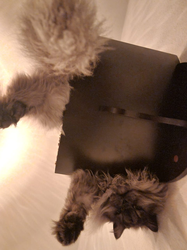

In [ ]:
#| eval: false
# %%fr +2 reply
import requests
from PIL import Image
from io import BytesIO

# Download an image of a cat
url = "https://cataas.com/cat"
response = requests.get(url)
img = Image.open(BytesIO(response.content))

# Resize the image
max_size = 250
ratio = max_size / max(img.size)
new_size = tuple([int(x*ratio) for x in img.size])
resized_img = img.resize(new_size, Image.LANCZOS)

# Display the resized image
resized_img

<details><summary style="display: list-item">🧠</summary>Now that we have the image, I'll describe it briefly in Jeremy Howard's style.</details>

Alright, let's take a quick gander at this furry feline! We've got a rather fluffy customer here, sprawled out in classic cat fashion. It's giving us a proper display of what I like to call "maximum relaxation mode". The cat's got this luxurious, long fur that's practically begging for a good brush. And would you look at that pose? It's the epitome of feline nonchalance, as if to say, "Yes, I'm fabulous, and I know it." This, folks, is what we in the biz call "peak cat". Absolutely brilliant!